In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from open_mycsv import CSVNameParser
from signal_tools import definition_set_g,g_convol_semilogx,autoco

In [2]:
def analyse_new_file(dirlist,idx):
    file = dirlist[idx]
    if file[-4:]=='.csv':
        parser = CSVNameParser(file)
        fcs_signal = np.loadtxt(str(path_container_folder+'/'+file), delimiter=";", dtype = str)
        fcs_signal = fcs_signal[:-1]
        fcs_signal = np.array([i for i in fcs_signal if i != ''], dtype= float)
        alpha,D = fcs_signal[1],fcs_signal[0]
        fcs_signal = np.sort(fcs_signal[3:])
        fcs_signal = fcs_signal[fcs_signal<t_max_experiment]
        if fcs_signal.size >0:
            photonbysec = fcs_signal.size/(fcs_signal[-1]-fcs_signal[0])
            for time in t_max_windows:
                evaluation_points = definition_set_g(time,points_number)
                autocorrelograms_estim = g_convol_semilogx(fcs_signal,
                                                            evaluation_points, time, points_number, time)
                for i in range(np.shape(autocorrelograms_estim)[0]):
                    new_row = {'window number' : i,'file name':file,'omega_x':parser.wxy,'omega':parser.w,
                                'Time window':time, 'G': autocorrelograms_estim[i][:],'alpha':alpha,'D':D,'Illumination':photonbysec,'Illu Params':parser.illu,'Model':parser.motion,'FCS':fcs_signal[(i*time<fcs_signal)&(fcs_signal<(i+1)*time)]}
                    dataframe.loc[len(dataframe)] = new_row
    else:
        print("Bad file format")
    return dataframe

In [3]:
def plot_all_on_same_figure(dataframe, idx_plot):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # Create a 2x2 grid for the subplots

    # Plot 1: G
    axs[0, 0].plot(dataframe.loc[idx_plot, 'G'])
    axs[0, 0].set_title('Plot of G')

    # Plot 2: FCS
    axs[0, 1].plot(dataframe.loc[idx_plot, 'FCS'])
    axs[0, 1].set_title('Plot of FCS')

    # Plot 3: Histogram of Signal
    signal = dataframe.loc[idx_plot, 'FCS']
    t_max = dataframe.loc[idx_plot, 'Time window']
    signal -= signal[0]
    num_bins = np.sum(signal <= t_max)
    signal_analysed, bins = np.histogram(signal, bins=num_bins, range=(0, t_max))
    axs[1, 0].plot(bins[:-1], signal_analysed)
    axs[1, 0].set_title('Histogram of Signal')

    # Plot 4: Signal Analysed with Mean Subtracted
    signal_analysed = signal_analysed - signal_analysed.mean()
    axs[1, 1].plot(signal_analysed)
    axs[1, 1].set_title('Signal Analysed (Mean Subtracted)')

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [4]:
path_container_folder = '/Users/nathanquiblier/Desktop/FCS_RWF'#illu_CTRWlast'
t_max_experiment = 2.1
colonnes=['window number' ,'file name','omega_x','omega','Time window','G','alpha','D','Illumination','Illu Params','Model','FCS']
dataframe = pd.DataFrame(columns=colonnes)
t_max_windows = [0.1,0.25,0.5,0.75,1.0,1.25,1.50,2.0]
points_number=1000
dirlist =  os.listdir(path=path_container_folder)
print('Number of files = ', len(dirlist))

Number of files =  12


In [5]:
idx = 1
dataframe = analyse_new_file(dirlist,idx)

alpha                0.970152
D                     3.21038
Illumination    103658.951187
Model                        
Time window               1.0
Name: 35, dtype: object


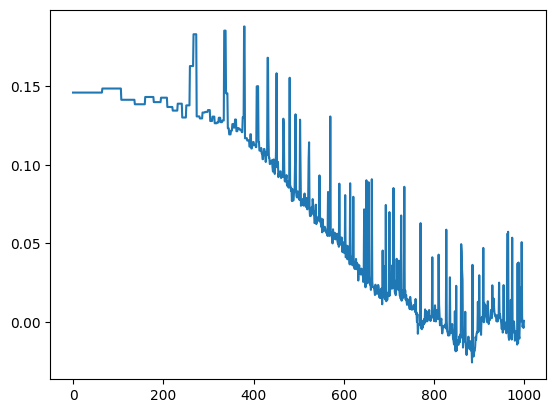

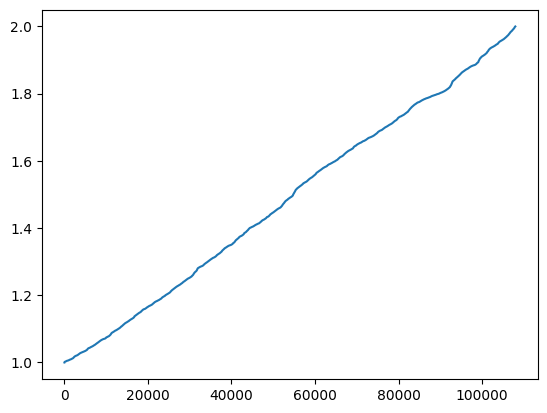

Min binned signal = 0
Number of min = 45467
Size signal = 107961


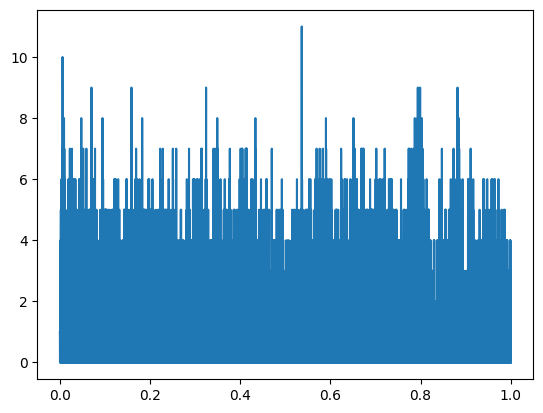

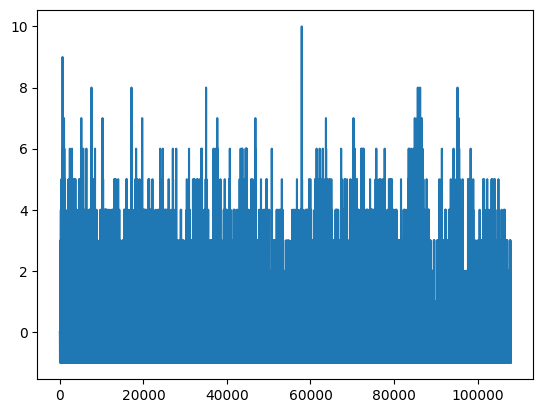

In [9]:
idx_plot = 35
print(dataframe.loc[idx_plot,['alpha','D','Illumination','Model','Time window']])

plt.plot(dataframe.loc[idx_plot,'G'])
plt.show()


plt.plot(dataframe.loc[idx_plot,'FCS'])
plt.show()

signal = dataframe.loc[idx_plot,'FCS']
t_max = dataframe.loc[idx_plot,'Time window']
signal -= signal[0]
num_bins = np.sum(signal <= t_max)
signal_analysed,bins = np.histogram(signal, bins=num_bins, range=(0, t_max))
print(f'Min binned signal = {signal_analysed.min()}')
print(f'Number of min = {np.sum(signal_analysed.min()==signal_analysed)}')
print(f'Size signal = {signal_analysed.size}')
plt.plot(bins[:-1],signal_analysed)
plt.show()


signal_analysed = signal_analysed - signal_analysed.mean()
plt.plot(signal_analysed)
plt.show()

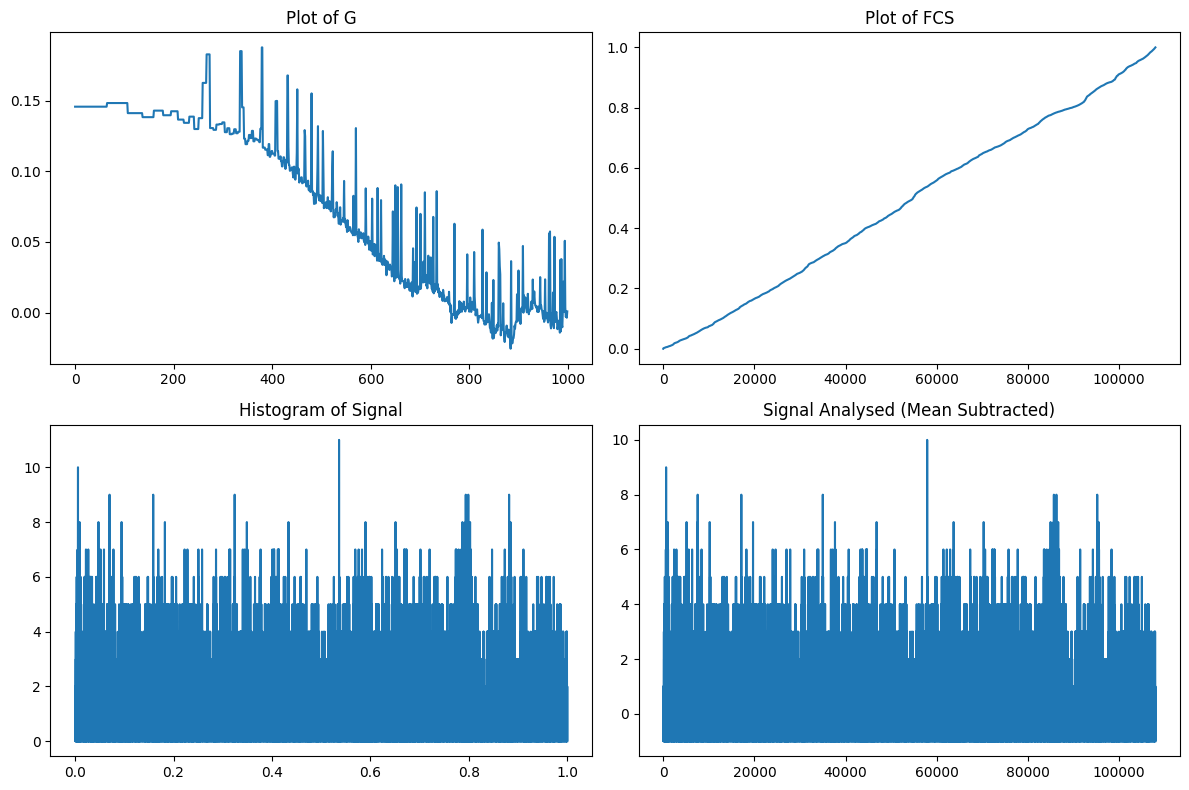

In [10]:
plot_all_on_same_figure(dataframe, idx_plot)

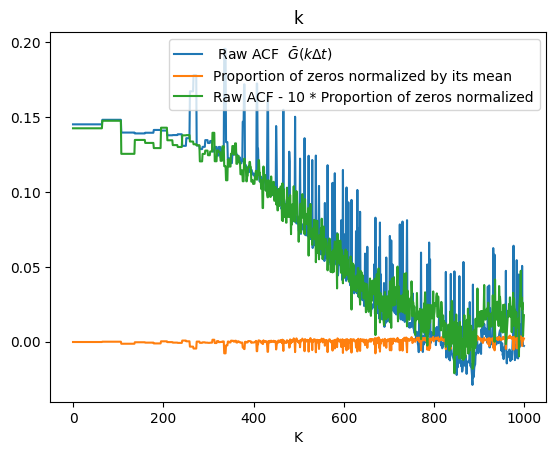

In [ ]:

num_bins = int(np.sum(signal <= t_max))
big_tau = definition_set_g(t_max,points_number)
g_signal = np.zeros(points_number)
number_zeros = np.zeros(points_number)
var = signal_analysed.var()
k = 0
for tau in big_tau[big_tau <= t_max / 2.0][:-1]:
    tau = int(tau * num_bins / t_max)
    g_signal[k] = autoco(signal_analysed, var, tau)
    number_zeros[k] = np.sum(np.multiply(signal_analysed[tau:], signal_analysed[:-tau])==0)/np.multiply(signal_analysed[tau:], signal_analysed[:-tau]).size
    k += 1
for tau in big_tau[big_tau > t_max / 2.0]:
    g_signal[k] = np.NaN
    k += 1


mean_error = -10*(number_zeros-number_zeros.mean())
plt.plot(g_signal,label =r' Raw ACF  $\hat{G}(k \Delta t)$')
plt.plot(number_zeros-number_zeros.mean(),label = 'Proportion of zeros normalized by its mean')
plt.plot(g_signal-mean_error,label = 'Raw ACF - 10 * Proportion of zeros normalized')
plt.legend()
plt.xlabel('K')
plt.title(r'k')
plt.show()

